In [262]:
import requests
from bs4 import BeautifulSoup
from pprint import pprint
import re
import pandas as pd
from get_file_from_url import get_file
import seaborn

## Scrape movie titles & Country names

In [2]:
#Takes an int arg 'n' = number of pages to scroll through for Foreign movie titles
#returns string list of ovie titles
def get_movie_titles(n):
    countries = []
    titles=[]
    for i in range(0,n):
        s1= 'http://www.boxofficemojo.com/genres/chart/?view=main&sort=gross&order=DESC&pagenum='
        s2= '&id=foreign.htm'
        url = '%s%d%s'%(s1, i+1, s2)
        response = get_file(url)
        page = response.text
        soup = BeautifulSoup(page)

        #look through all links 'a'
        for item in soup.find_all('a'):
            children = []
            #if the movie folder is in item row AND not the aprophet move(ascii error)
            if "/movies/?id" in str(item):           
            #this next loop gets rid of outer tag and goes into bold tag
                for child in item.descendants:
                    #put child in children temp list
                    children.append(child)
                    #into the bold tag
                for child in children:
                    if "<b>" not in child.string:
                        country = None
                        s = str(child.parent.parent)
                        if type(s) != None:
                            br_list = s.split('<br/>')
                            if len(br_list)==2:
                                country = br_list[1].split(')')[0][1:]
                        if child.string not in titles:
                            countries.append(country)
                            titles.append(child.string)


        #remove upcoming release titles
        del titles[-7:]
    #remove  header movie
    titles.pop(0)
    return countries, titles   

In [3]:
countries, m_titles=get_movie_titles(18)

## Clean up title names

In [5]:
#takes a movie list as an argument
#Removes all chars after ':' in a string
#removes all non letter characters &  word'the' from title
#returns a list of clean movie titles
def clean_titles(m_list):
    movies= []
    validChars='abcdefghijklmnopqrstuvwxyz:'
    newString = ''
    sub_string=''
    
    for m in m_list:
        #split string
        if ':' in m:
            for i in range(0, len(m)):
                if m[i] == ':':
                    sub_string = m[:i]
            m = sub_string
        temp = m.lower()
        #remove non letter characters
        for char in temp:
            if char in validChars:
                newString += char
        #get this to remove only from the front of the title!
        #remove 'the' from title
        movies.append(newString.replace('the', ''))
        newString = ''       
     
    return movies

In [6]:
c_titles=clean_titles(m_titles)
c_titles[:5]

[u'crouchingtigerhiddendragon',
 u'lifeisbeautiful',
 u'hero',
 u'instructionsnotincluded',
 u'panslabyrinth']

## Get feature values & clean them

In [7]:
#takes a soup obj of html page & the field name
#returns value of field name
def get_values(soup, field_name):
    obj = soup.find(text=re.compile(field_name))
    if not obj: 
        return None
    next_sibling = obj.findNextSibling()
    if next_sibling:
        return next_sibling.text 
    else:
        return None

#takes string: domestic total gross & removes all non number characters
def clean_domestic_total_gross(dtg):
    dom = str(dtg).replace('$', '').replace(',', '')
    return (dom)

def clean_currency(c):
    curr = str(c).replace('$','').replace(',','').replace('million', '000000').replace("N/A", 0)
    #print c
    currency = int(curr)    
    return currency

def clean_budget(b):
    op_budget = str(b).replace('$', '').replace(' ','').replace('million', '000000').replace('N/A','0')
    operating_budget = (op_budget)
    return operating_budget


#takes a string for budget and removes all non number characters
#def clean_budget(b):
    #operating_budget = str(b).replace('$', '').replace(' ','').replace('million', '000000').replace('N/A','0')




In [8]:
c_titles[0]

u'crouchingtigerhiddendragon'

## Function that gets all features for each movie

In [9]:
#take clean list of movies (c_titles) and go to each page

def get_movie_info(movie_list,countries):
    movie_info = []
    s1='http://www.boxofficemojo.com/movies/?id='
    s2= '.htm'
        
    for i in range(0, len(movie_list)):
        
        title= movie_list[i]
        url = '%s%s%s'%(s1,title, s2)
        response = get_file(url)
        if response is not None:
            if response.status_code==200:
            
                page = response.text
                soup = BeautifulSoup(page)

                #domestic Total Gross
                dtg= get_values(soup, "Domestic Total Gross: ")
                #print dtg
                domestic_gross = clean_domestic_total_gross(dtg)
                
                #print domestic_gross

                #ratings
                rtg = get_values(soup, 'MPAA Rating: ')
                ratings = str(rtg)
                #print ratings

                #genre 
                genre= get_values(soup, "Genre: ")
                #print genre

                #runtime
                r_time = get_values(soup, "Runtime: ")
                runtime= str(r_time)
                #print runtime

                #releasedate
                r_date = get_values(soup, "Release Date: ")
                release_date = str(r_date)
                #print release_date

                #operating budget
                budget = get_values(soup, 'Production Budget: ')
                operating_budget = clean_budget(budget)
                #print operating_budget

                #countries
                country= countries[i]

                #print movie_info
                #return movie_info
                movie_info.append((title,country, domestic_gross, ratings, genre, runtime, release_date,operating_budget))

                #global count 
                #count +=1
            else:
                print url
        else:
            print url
    return movie_info
            
#print my_list

In [10]:
my_list=get_movie_info(c_titles,countries)

Error: request.get(url) Status NOT 200
http://www.boxofficemojo.com/movies/?id=likefarlikeson.htm
Error: request.get(url) Status NOT 200
http://www.boxofficemojo.com/movies/?id=marriageitalianstylererelease.htm


In [16]:
my_list[0]

title = []
gross_dom_prod = []
mpaa_rating = []
genre = []
runtime = []
release date = []
budget = []

(u'crouchingtigerhiddendragon',
 None,
 '128078872',
 'PG-13',
 u'Foreign / Action',
 '2 hrs. 0 min.',
 'December 8, 2000',
 '17000000')

In [48]:
type(my_list[0][4])

unicode

In [13]:
type(my_list[-1])

tuple

In [16]:

import pickle
pickle.dump(my_list,open('./data.p','wb'))
my_data = pickle.load(open('./data.p', 'rb'))



# Load in dataset

In [18]:
import pickle 
my_data = pickle.load(open('./data.p', 'rb'))

# Data loaded

In [14]:
print my_list[0][0]
#print m_titles[0]

crouchingtigerhiddendragon


In [18]:
my_data[:5]

[(u'crouchingtigerhiddendragon',
  None,
  '128078872',
  'PG-13',
  u'Foreign / Action',
  '2 hrs. 0 min.',
  'December 8, 2000',
  '17000000'),
 (u'lifeisbeautiful',
  'Taiwan',
  '57247384',
  'PG-13',
  u'Foreign',
  '1 hrs. 56 min.',
  'October 23, 1998',
  '0'),
 (u'hero',
  'Italy',
  '19507345',
  'PG-13',
  u'Comedy',
  '1 hrs. 58 min.',
  'October 2, 1992',
  '0'),
 (u'instructionsnotincluded',
  'China',
  '44467206',
  'PG-13',
  u'Foreign',
  '1 hrs. 55 min.',
  'August 30, 2013',
  '0'),
 (u'panslabyrinth',
  None,
  '37634615',
  'R',
  u'Foreign / Horror',
  '1 hrs. 52 min.',
  'December 29, 2006',
  '19000000')]

In [19]:
df=pd.DataFrame(my_data)
df[:3]

,0,1,2,3,4,5,6,7
0,crouchingtigerhiddendragon,None,128078872,PG-13,Foreign / Action,2 hrs. 0 min.,"December 8, 2000",17000000
1,lifeisbeautiful,Taiwan,57247384,PG-13,Foreign,1 hrs. 56 min.,"October 23, 1998",0
2,hero,Italy,19507345,PG-13,Comedy,1 hrs. 58 min.,"October 2, 1992",0


In [20]:
df.head()

,0,1,2,3,4,5,6,7
0,crouchingtigerhiddendragon,None,128078872,PG-13,Foreign / Action,2 hrs. 0 min.,"December 8, 2000",17000000
1,lifeisbeautiful,Taiwan,57247384,PG-13,Foreign,1 hrs. 56 min.,"October 23, 1998",0
2,hero,Italy,19507345,PG-13,Comedy,1 hrs. 58 min.,"October 2, 1992",0
3,instructionsnotincluded,China,44467206,PG-13,Foreign,1 hrs. 55 min.,"August 30, 2013",0
4,panslabyrinth,None,37634615,R,Foreign / Horror,1 hrs. 52 min.,"December 29, 2006",19000000


In [49]:
copy_df = pd.read_csv('foreign.csv')

In [50]:
copy_df.head()

,0,crouchingtigerhiddendragon,lifeisbeautiful,hero,instructionsnotincluded,panslabyrinth,amelie,jetlisfearless,ilpostino,likewaterforchocolate,...,whitepalms,cash,kidnap,moscowbelgium,edenlog,aashayeinwishes,chakjawanagoforit,itsawonderfulafterlife,skyturnselcielogira,hauntedd
0,1,NaN,Taiwan,Italy,China,NaN,Mexico,France,China,Italy,...,NaN,NaN,Hong Kong,NaN,Germany,Thailand,Italy,NaN,China,Denmark
1,2,128078872,57247384,19507345,44467206,37634615,33225499,None,21848932,21665468,...,None,None,None,None,None,None,None,None,None,None
2,3,PG-13,PG-13,PG-13,PG-13,R,R,None,PG,R,...,Unrated,Unrated,None,Unrated,R,None,None,None,None,None
3,4,Foreign / Action,Foreign,Comedy,Foreign,Foreign / Horror,Foreign,NaN,Foreign,Foreign,...,Foreign,Foreign,NaN,Foreign,Foreign,NaN,NaN,NaN,NaN,NaN
4,5,2 hrs. 0 min.,1 hrs. 56 min.,1 hrs. 58 min.,1 hrs. 55 min.,1 hrs. 52 min.,2 hrs. 2 min.,None,1 hrs. 48 min.,1 hrs. 45 min.,...,1 hrs. 37 min.,2 hrs. 25 min.,None,1 hrs. 42 min.,NaN,None,None,None,None,None


# Rename Columns

In [22]:
df.columns = ['Movie', 'Country', 'GDP', 'MPAA', 'Genre','Runtime','Release_date', 'Budget']

In [23]:
df.head()

,Movie,Country,GDP,MPAA,Genre,Runtime,Release_date,Budget
0,crouchingtigerhiddendragon,None,128078872,PG-13,Foreign / Action,2 hrs. 0 min.,"December 8, 2000",17000000
1,lifeisbeautiful,Taiwan,57247384,PG-13,Foreign,1 hrs. 56 min.,"October 23, 1998",0
2,hero,Italy,19507345,PG-13,Comedy,1 hrs. 58 min.,"October 2, 1992",0
3,instructionsnotincluded,China,44467206,PG-13,Foreign,1 hrs. 55 min.,"August 30, 2013",0
4,panslabyrinth,None,37634615,R,Foreign / Horror,1 hrs. 52 min.,"December 29, 2006",19000000


# End column rename

# Data exploration

In [263]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [74]:
df.shape

(1797, 8)

In [31]:
df.head()

,Movie,Country,GDP,MPAA,Genre,Runtime,Release_date,Budget
0,crouchingtigerhiddendragon,None,128078872,PG-13,Foreign / Action,2 hrs. 0 min.,"December 8, 2000",17000000
1,lifeisbeautiful,Taiwan,57247384,PG-13,Foreign,1 hrs. 56 min.,"October 23, 1998",0
2,hero,Italy,19507345,PG-13,Comedy,1 hrs. 58 min.,"October 2, 1992",0
3,instructionsnotincluded,China,44467206,PG-13,Foreign,1 hrs. 55 min.,"August 30, 2013",0
4,panslabyrinth,None,37634615,R,Foreign / Horror,1 hrs. 52 min.,"December 29, 2006",19000000


## Budget

In [37]:
df['Budget'] = [None if i == 'None' else float(i.replace(",", "")) for i in df['Budget']]

(array([  1.32200000e+03,   4.00000000e+00,   1.20000000e+01,
          3.00000000e+00,   2.00000000e+00,   4.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          2.00000000e+00]),
 array([        0.,   8500000.,  17000000.,  25500000.,  34000000.,
         42500000.,  51000000.,  59500000.,  68000000.,  76500000.,
         85000000.]),
 <a list of 10 Patch objects>)

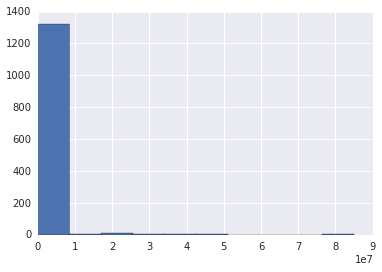

In [264]:
plt.hist(df[df['Budget'].notnull()]['Budget'])

In [79]:
print "Number of movies with missing budget: {}".format(df[~df['Budget'].notnull()].shape[0])

Number of movies with missing budget: 446


In [68]:
boolean = df[df['Budget'].notnull()]['Budget'] == 0.0

In [83]:
print "Number of movies with non-zero budget: {}".format(df[df['Budget'].notnull()][~boolean].shape[0])
print "Number of movies with zero budget: {}".format(df[df['Budget'].notnull()][boolean].shape[0])

Number of movies with non-zero budget: 51
Number of movies with zero budget: 1300


In [84]:
bud_cat = []
for i in df['Budget']:
    if i is None:
        bud_cat.append('None')
    elif i == 0.0:
        bud_cat.append('zero')
    else:
        bud_cat.append('real')
df['BudgetCategory'] = bud_cat

## GDP

In [94]:
df['GDP'] = [None if i == 'None' else float(i.replace(",", "")) for i in df['GDP']]

In [99]:
print "Number of movies with missing GDP: {}".format(df[~df['GDP'].notnull()].shape[0])
print "Number of movies with GDP: {}".format(df[df['GDP'].notnull()].shape[0])

Number of movies with missing GDP: 563
Number of movies with GDP: 1234


(array([  1.14300000e+03,   3.50000000e+01,   1.60000000e+01,
          1.00000000e+01,   5.00000000e+00,   2.00000000e+00,
          9.00000000e+00,   1.00000000e+00,   2.00000000e+00,
          0.00000000e+00,   2.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          2.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          1.00000000e+00]),
 array([  8.00000000e+01,   5.38041884e+06,   1.07607577e+07,
          1.61410965e+07,   2.15214354e+07,   2.69017742e+07,
          3.22821130e+07,   3.76624519e+07,   4.30427907e+07,
          4.84231296e+07,   5.38034684e+07,   5.91838072e+07,
          6.45641461e+07,   6.99444849e+07,   7.53248238e+07,
          8.07051626e+07,   8.60855014e+07,   9.14658403e+07,
          9.68461791e+07,   1.02226518e+08,   1.07606857e+08,
          1.12987196e+08,   1.18367534e+08

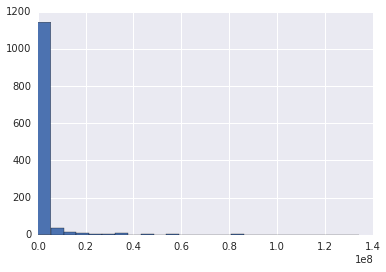

In [265]:
plt.hist(df[df['GDP'].notnull()]['GDP'], bins = 25)

(array([   1.,   21.,   66.,  182.,  220.,  251.,  281.,  148.,   41.,   23.]),
 array([  4.38202663,   5.8155378 ,   7.24904897,   8.68256014,
         10.11607131,  11.54958248,  12.98309365,  14.41660482,
         15.85011599,  17.28362716,  18.71713833]),
 <a list of 10 Patch objects>)

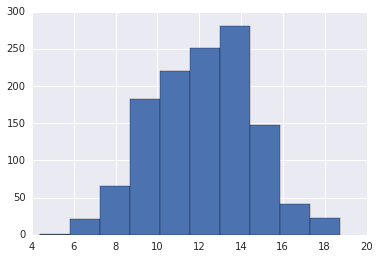

In [266]:
plt.hist(np.log(np.array(df[df['GDP'].notnull()]['GDP'])))

In [109]:
df['log_GDP'] = [None if i is None else np.log(i) for i in df['GDP']]

In [110]:
df.head()

,Movie,Country,GDP,MPAA,Genre,Runtime,Release_date,Budget,BudgetCategory,log_GDP
0,crouchingtigerhiddendragon,None,128078872,PG-13,Foreign / Action,2 hrs. 0 min.,"December 8, 2000",17000000,real,18.668157
1,lifeisbeautiful,Taiwan,57247384,PG-13,Foreign,1 hrs. 56 min.,"October 23, 1998",0,zero,17.862893
2,hero,Italy,19507345,PG-13,Comedy,1 hrs. 58 min.,"October 2, 1992",0,zero,16.786302
3,instructionsnotincluded,China,44467206,PG-13,Foreign,1 hrs. 55 min.,"August 30, 2013",0,zero,17.610263
4,panslabyrinth,None,37634615,R,Foreign / Horror,1 hrs. 52 min.,"December 29, 2006",19000000,real,17.443435


## Runtime

In [116]:
run_cat = []
hours = []
minutes = []
for i in df['Runtime']:
    if i == 'N/A':
        run_cat.append('NA')
        hours.append(0.0)
        minutes.append(0.0)
    elif i == 'None':
        run_cat.append('None')
        hours.append(0.0)
        minutes.append(0.0)
    else:
        run_cat.append('Real')
        tmp = i.split()
        hours.append(float(tmp[0]))
        minutes.append(float(tmp[2]))

In [117]:
df['run_cat'] = run_cat
df['hours'] = hours
df['minutes'] = minutes

In [120]:
df['total_minutes'] = df['hours']*60 + df['minutes']

In [121]:
df.head()

,Movie,Country,GDP,MPAA,Genre,Runtime,Release_date,Budget,BudgetCategory,log_GDP,run_cat,hours,minutes,total_minutes
0,crouchingtigerhiddendragon,None,128078872,PG-13,Foreign / Action,2 hrs. 0 min.,"December 8, 2000",17000000,real,18.668157,Real,2,0,120
1,lifeisbeautiful,Taiwan,57247384,PG-13,Foreign,1 hrs. 56 min.,"October 23, 1998",0,zero,17.862893,Real,1,56,116
2,hero,Italy,19507345,PG-13,Comedy,1 hrs. 58 min.,"October 2, 1992",0,zero,16.786302,Real,1,58,118
3,instructionsnotincluded,China,44467206,PG-13,Foreign,1 hrs. 55 min.,"August 30, 2013",0,zero,17.610263,Real,1,55,115
4,panslabyrinth,None,37634615,R,Foreign / Horror,1 hrs. 52 min.,"December 29, 2006",19000000,real,17.443435,Real,1,52,112


(array([ 514.,    0.,    0.,    9.,  189.,  473.,  314.,  163.,   79.,
          35.,   12.,    2.,    2.,    1.,    2.,    0.,    0.,    1.,
           0.,    1.]),
 array([   0. ,   18.3,   36.6,   54.9,   73.2,   91.5,  109.8,  128.1,
         146.4,  164.7,  183. ,  201.3,  219.6,  237.9,  256.2,  274.5,
         292.8,  311.1,  329.4,  347.7,  366. ]),
 <a list of 20 Patch objects>)

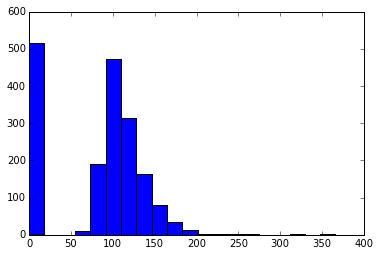

In [123]:
plt.hist(df['total_minutes'], bins = 20)

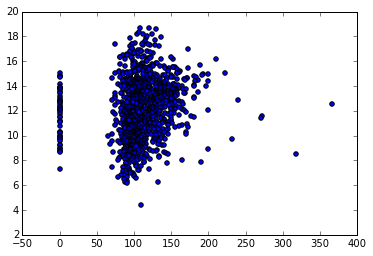

In [124]:
plt.scatter(df['total_minutes'], df['log_GDP'])

In [129]:
df['Country'].value_counts()

France                  142
India                   108
Japan                    40
Italy                    31
China                    30
Germany                  30
Spain                    26
Hungary                  19
Mexico                   18
Russia                   13
Argentina                12
Hong Kong                11
Sweden                   11
Israel                   11
South Korea              10
Brazil                   10
French Canada             9
Denmark                   9
Norway                    7
Czech Republic            5
Iran                      5
Thailand                  5
Belgium                   5
Taiwan                    5
Turkey                    5
Holland                   4
Czech                     3
Cuba                      3
Korea                     2
Philippines               2
                       ... 
Romania                   2
Switzerland               2
Vietnam                   2
Macedonia                 2
Peru                

In [138]:
c1 = []
c2 = []
for i in df['Genre']:
    if i is None:
        c1.append('None')
        c2.append('None')
    else:
        tmp = i.replace('/', '').split()
        if len(tmp) == 1:
            c1.append(tmp[0])
            c2.append('None')
        else:
            c1.append(tmp[0])
            c2.append(tmp[1])

In [139]:
df['c1'] = c1
df['c2'] = c2

In [154]:
df = pd.get_dummies(df, columns = ['c1', 'c2'])

In [157]:
df['adventure'] = df['c1_Adventure'] +  df['c2_Adventure']
df['Thriller'] = df['c1_Thriller'] +  df['c2_Thriller']
df['Animation'] = df['c1_Animation' ]   
df['Comedy'] = df['c1_Comedy'] +  df['c2_Comedy']
df['Crime'] = df['c1_Crime']
df['Documentary'] = df['c1_Documentary']      
df['Drama'] = df['c1_Drama'] +  df['c2_Drama']
df['Family'] = df['c1_Family'] 
df['Foreign'] = df['c1_Foreign']     
df['Horror'] = df['c1_Horror'] +  df['c2_Horror']
df['Music'] = df['c1_Music']          
df['Period'] = df['c1_Period']
df['Romance'] = df['c1_Romance'] + df['c1_Romantic']
df['Sci-Fi'] = df['c1_Sci-Fi']
df['Unknown'] = df['c1_Unknown']    
df['War'] = df['c1_War']
df['Fantasy'] = df['c2_Fantasy']
df['Action'] = df['c1_Action'] +  df['c2_Action']

In [160]:
df = pd.get_dummies(df, columns = ['MPAA'])

In [162]:
cntry = ['France', 'India', 'Japan','Italy',  'China','Germany', 'Spain']   

In [164]:
df['new_country'] = [i if i in cntry else 'other' for i in df['Country']]

In [166]:
df = pd.get_dummies(df, columns = ['new_country'])

In [167]:
df.head()

,Movie,Country,GDP,Genre,Runtime,Release_date,Budget,BudgetCategory,log_GDP,run_cat,...,MPAA_R,MPAA_Unrated,new_country_China,new_country_France,new_country_Germany,new_country_India,new_country_Italy,new_country_Japan,new_country_Spain,new_country_other
0,crouchingtigerhiddendragon,None,128078872,Foreign / Action,2 hrs. 0 min.,"December 8, 2000",17000000,real,18.668157,Real,...,0,0,0,0,0,0,0,0,0,1
1,lifeisbeautiful,Taiwan,57247384,Foreign,1 hrs. 56 min.,"October 23, 1998",0,zero,17.862893,Real,...,0,0,0,0,0,0,0,0,0,1
2,hero,Italy,19507345,Comedy,1 hrs. 58 min.,"October 2, 1992",0,zero,16.786302,Real,...,0,0,0,0,0,0,1,0,0,0
3,instructionsnotincluded,China,44467206,Foreign,1 hrs. 55 min.,"August 30, 2013",0,zero,17.610263,Real,...,0,0,1,0,0,0,0,0,0,0
4,panslabyrinth,None,37634615,Foreign / Horror,1 hrs. 52 min.,"December 29, 2006",19000000,real,17.443435,Real,...,1,0,0,0,0,0,0,0,0,1


In [169]:
df = pd.get_dummies(df, columns = ['BudgetCategory'])

# End data exploration

# Modelling 

In [171]:
col = [ 'log_GDP',
 'total_minutes',
 'adventure',
 'Thriller',
 'Animation',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Foreign',
 'Horror',
 'Music',
 'Period',
 'Romance',
 'Sci-Fi',
 'Unknown',
 'War',
 'Fantasy',
 'Action',
 'MPAA_G',
 'MPAA_NC-17',
 'MPAA_None',
 'MPAA_Not Yet Rated',
 'MPAA_PG',
 'MPAA_PG-13',
 'MPAA_R',
 'MPAA_Unrated',
 'new_country_China',
 'new_country_France',
 'new_country_Germany',
 'new_country_India',
 'new_country_Italy',
 'new_country_Japan',
 'new_country_Spain',
 'new_country_other',
 'BudgetCategory_real',
 'BudgetCategory_zero']

In [179]:
feats = ['total_minutes',
 'adventure',
 'Thriller',
 'Animation',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Foreign',
 'Horror',
 'Music',
 'Period',
 'Romance',
 'Sci-Fi',
 'Unknown',
 'War',
 'Fantasy',
 'Action',
 'MPAA_G',
 'MPAA_NC-17',
 'MPAA_None',
 'MPAA_Not Yet Rated',
 'MPAA_PG',
 'MPAA_PG-13',
 'MPAA_R',
 'MPAA_Unrated',
 'new_country_China',
 'new_country_France',
 'new_country_Germany',
 'new_country_India',
 'new_country_Italy',
 'new_country_Japan',
 'new_country_Spain',
 'new_country_other',
 'BudgetCategory_real',
 'BudgetCategory_zero']

In [177]:
data = df[df['log_GDP'].notnull()][col]

In [178]:
data.head()

,log_GDP,total_minutes,adventure,Thriller,Animation,Comedy,Crime,Documentary,Drama,Family,...,new_country_China,new_country_France,new_country_Germany,new_country_India,new_country_Italy,new_country_Japan,new_country_Spain,new_country_other,BudgetCategory_real,BudgetCategory_zero
0,18.668157,120,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
1,17.862893,116,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
2,16.786302,118,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
3,17.610263,115,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
4,17.443435,112,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0


In [180]:
from sklearn.linear_model import LinearRegression
rgr = LinearRegression()
rgr.fit(data[feats].values, data['log_GDP'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

## Statsmodels

In [184]:
import statsmodels.api as sm
import statsmodels.formula.api as ols

In [187]:
model = sm.OLS(data[['log_GDP']], data[feats]).fit()

original p-values

In [188]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                log_GDP   R-squared:                       0.361
Model:                            OLS   Adj. R-squared:                  0.344
Method:                 Least Squares   F-statistic:                     21.19
Date:                Thu, 28 Jan 2016   Prob (F-statistic):           1.92e-94
Time:                        17:11:17   Log-Likelihood:                -2549.1
No. Observations:                1234   AIC:                             5164.
Df Residuals:                    1201   BIC:                             5333.
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
total_minutes           0.0121      0.002      7.513      0.000         0.009     0.015
adventure              -0.6609      1.142     -0.579      0.563        -2.902     1.580
Thriller                0.3779      0.830      0.455      0.649        -1.251     2.007
Animation              -1.6023      1.285     -1.247      0.213        -4.124     0.919
Comedy                 -0.0254      0.700     -0.036      0.971        -1.400     1.349
Crime                  -0.3351      2.059     -0.163      0.871        -4.376     3.705
Documentary            -3.5348      1.049     -3.368      0.001        -5.594    -1.476
Drama                  -1.9015      0.821     -2.316      0.021        -3.512    -0.291
Family                 -5.9479      2.101     -2.831      0.005       -10.071    -1.825
Foreign                -2.3880      0.688     -3.472      0.001        -3.738    -1.039
Horror                  0.1022      0.505      0.203      0.840        -0.888     1.092
Music                   2.1702      1.528      1.420      0.156        -0.827     5.168
Period                  1.2873      1.010      1.275      0.203        -0.694     3.269
Romance                 0.4896      0.810      0.605      0.545        -1.099     2.078
Sci-Fi                  0.8786      1.546      0.568      0.570        -2.154     3.911
Unknown                -2.6692      0.747     -3.572      0.000        -4.135    -1.203
War                     3.7602      2.043      1.840      0.066        -0.249     7.769
Fantasy             -7.808e-16   1.37e-15     -0.568      0.570     -3.48e-15  1.91e-15
Action                  0.3250      0.256      1.271      0.204        -0.177     0.827
MPAA_G                  4.6380      0.812      5.710      0.000         3.044     6.232
MPAA_NC-17              2.3665      0.749      3.158      0.002         0.896     3.837
MPAA_None            1.613e-15   5.61e-16      2.872      0.004      5.11e-16  2.71e-15
MPAA_Not Yet Rated      0.0247      1.263      0.020      0.984        -2.454     2.503
MPAA_PG                 3.8111      0.353     10.800      0.000         3.119     4.503
MPAA_PG-13              3.7278      0.308     12.093      0.000         3.123     4.333
MPAA_R                  3.2437      0.277     11.721      0.000         2.701     3.787
MPAA_Unrated            1.5487      0.273      5.673      0.000         1.013     2.084
new_country_China       3.1760      0.429      7.400      0.000         2.334     4.018
new_country_France      2.4954      0.240     10.382      0.000         2.024     2.967
new_country_Germany     2.2189      0.425      5.217      0.000         1.385     3.053
new_country_India       2.6328      0.253     10.395      0.000         2.136     3.130
new_country_Italy       2.5354      0.410      6.189      0.000         1.732     3.339
new

In [260]:
Y=data.iloc[:,:1]
#X=data.iloc[:,1:]


X=data[['total_minutes', 'Documentary','Action','Family','War', 'MPAA_R','new_country_China','new_country_France', 'new_country_Germany','new_country_India','new_country_Italy','new_country_Japan','new_country_Spain']]      

## Model 2- second summary

In [261]:
model2 = sm.OLS(Y,X).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                log_GDP   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                     956.5
Date:                Thu, 28 Jan 2016   Prob (F-statistic):               0.00
Time:                        22:11:13   Log-Likelihood:                -3369.1
No. Observations:                1234   AIC:                             6764.
Df Residuals:                    1221   BIC:                             6831.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
total_minutes           0.0930      0.001     81.276      0.000         0.091     0.095
Documentary            -0.2076      1.528     -0.136      0.892        -3.205     2.790
Action                  0.8770      0.473      1.856      0.064        -0.050     1.804
Family                 -2.4134      3.828     -0.630      0.529        -9.924     5.097
War                     2.7372      3.738      0.732      0.464        -4.597    10.071
MPAA_R                  2.6660      0.249     10.723      0.000         2.178     3.154
new_country_China       2.6928      0.865      3.115      0.002         0.997     4.389
new_country_France      2.1288      0.384      5.547      0.000         1.376     2.882
new_country_Germany     1.9167      0.842      2.275      0.023         0.264     3.569
new_country_India       1.5440      0.431      3.578      0.000         0.697     2.390
new_country_Italy       3.2745      0.821      3.989      0.000         1.664     4.885
new_country_Japan      -0.0426      0.758     -0.056      0.955        -1.530     1.445
new_country_Spain       1.5775      1.006      1.568      0.117        -0.397     3.552
==============================================================================
Omnibus:                      140.145   Durbin-Watson:                   1.722
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1143.824
Skew:                           0.133   Prob(JB):                    4.19e-249
Kurtosis:                       7.709   Cond. No.                     4.15e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.15e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

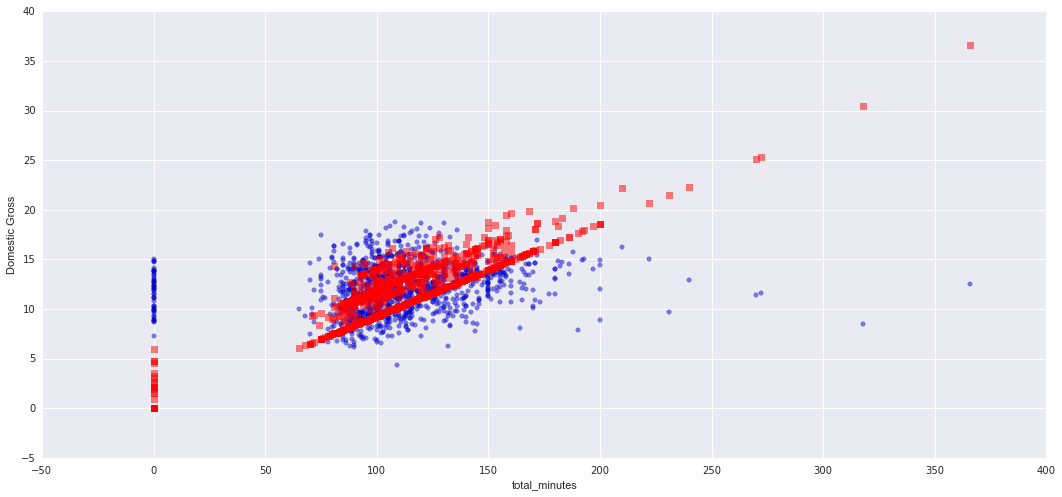

In [274]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(18,8))
plt.scatter(X.total_minutes, Y, alpha=0.5)
plt.plot(X.total_minutes, model2.predict(X), 'rs', alpha=.5)
plt.xlabel('total_minutes')
plt.ylabel('Domestic Gross')

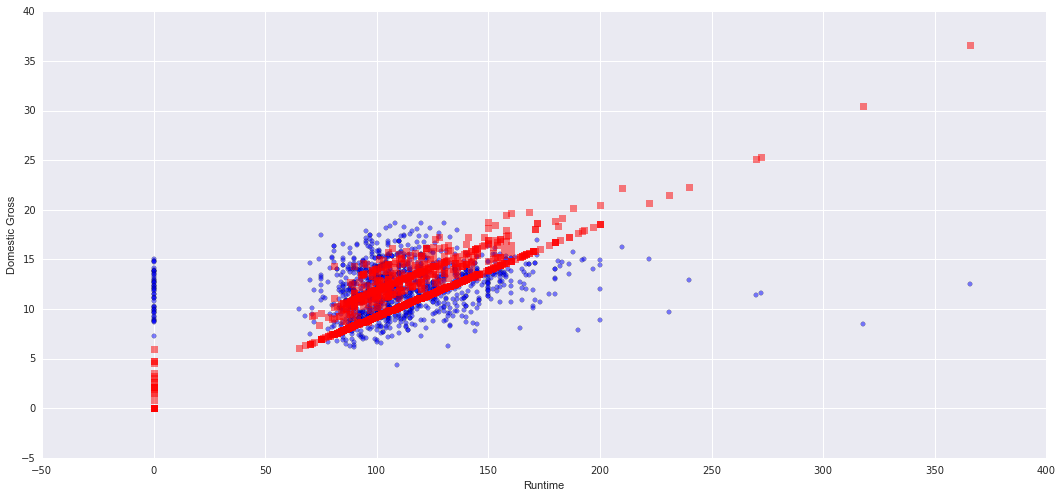

In [267]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(18,8))
plt.scatter(X.total_minutes, Y, alpha=0.5)
plt.plot(X.total_minutes, model2.predict(X), 'rs', alpha=.5)
plt.xlabel('Runtime')
plt.ylabel('Domestic Gross')


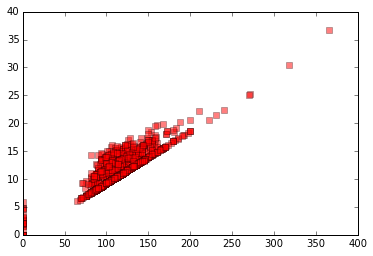

In [181]:
rgr.predict(data[feats].values)

array([ 15.41489895,  13.3930814 ,  16.52723828, ...,  11.40830147,
        10.89818587,  11.12895245])

In [182]:
#coefficients show impact hvg on y
rgr.coef_

array([  1.21456096e-02,  -6.60923127e-01,   3.77930357e-01,
        -1.60230972e+00,  -2.53588876e-02,  -3.35124814e-01,
        -3.53476571e+00,  -1.90145672e+00,  -5.94792349e+00,
        -2.38801957e+00,   1.02208824e-01,   2.17016494e+00,
         1.28733585e+00,   4.89631559e-01,   8.78587908e-01,
        -2.66922950e+00,   3.76020675e+00,   5.98538214e-16,
         3.25015844e-01,   1.87219033e+00,  -3.99326963e-01,
         7.55444873e-16,  -2.74111595e+00,   1.04535727e+00,
         9.62042768e-01,   4.77919460e-01,  -1.21706691e+00,
         7.55972804e-01,   7.53311262e-02,  -2.01167677e-01,
         2.12730243e-01,   1.15350768e-01,  -4.81278611e-01,
         1.54915555e-01,  -6.31854208e-01,   8.24109635e-01,
        -8.24109635e-01])

# End modelling